In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-1bqlzp7t
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-1bqlzp7t


In [ ]:
pip install scikit-plot

In [ ]:
! pip install neptune-client

# Índice:

[Pre-processamento dos dados](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=DKIibpN_B4tA)

[Criando um modelo de baseline](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=4FRzNtZRaRf7)

[Selecionando as melhores features](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=3QsOBE8yZmzO)

[Selecionando os hiperparâmetros](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=50tCoK4O9wjL)

[Modelos](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=3Fbvz48y9yl1&line=1&uniqifier=1)

[Selecionando os melhores modelos](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=ZHYrkuHI6cfy)

[Gráficos de Desempenho](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=fAh0GVFoEjKp)

[Salvando os modelos](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=1OsqF63vwQCr)

[Conclusão](https://colab.research.google.com/drive/1zaHJ7B1rMfzao_fgmAVXwxYY4GR-paKR#scrollTo=IIrtU-TyEO8o)

In [ ]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
import sklearn.metrics as metrics
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from hpsklearn import HyperoptEstimator, any_classifier, any_preprocessing
from hyperopt import tpe
import scikitplot as skplt
from scikitplot.metrics import plot_ks_statistic
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scipy.stats import ks_2samp
from joblib import dump, load

WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


# **Importando o dataset e Pre-processamento dos dados**

In [ ]:
# Carregando a base de dados
url = 'https://github.com/tathi-martins/Predict_ICU_for_COVID-19/raw/main/DATA/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(url)

In [ ]:
# Primeira olhada nos dados
dados

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

In [ ]:
# Visualizando valores NaNs 

def valores_nulos(dados):
    
    # Calculando e ordenando os nulos 
    nulos = dados.isnull().sum()
    total_nulos = nulos.sort_values(ascending=False)
    
    # Calculando a porcentagem 
    porcentagem = (nulos / len(dados.index)*100).round(2).sort_values(ascending=False)

    df_nulos = pd.concat([total_nulos, porcentagem], axis=1, keys=['Número de nulos', 'Porcentagem de dados nulos'])
  
    return df_nulos.head(10)


valores_nulos(dados)

,Número de nulos,Porcentagem de dados nulos
P02_VENOUS_MIN,1104,57.35
HEMOGLOBIN_MEAN,1104,57.35
LACTATE_MIN,1104,57.35
LACTATE_MEAN,1104,57.35
LACTATE_MEDIAN,1104,57.35
INR_DIFF,1104,57.35
INR_MAX,1104,57.35
INR_MIN,1104,57.35
INR_MEAN,1104,57.35
INR_MEDIAN,1104,57.35


In [ ]:
def preenche_tabela(dados):
    float_columns = dados.select_dtypes(include=['float64']).columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[float_columns].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :4]
    saida = dados.iloc[:, -2:]
    df = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    df.columns = dados.columns
    return df

In [ ]:
dados_finais = preenche_tabela(dados)
dados_finais

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.272727,-0.275362,0.736842,-0.339130,0.325153,0.114504,0.176471,-1.000000,-1.000000,-0.389967,0.407558,-0.230462,0.096774,-1.000000,-1.000000,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,-0.107143,0.736842,-0.283951,-0.376923,-0.188679,-0.379310,-0.107143,0.736842,-0.340206,-0.4875,-0.572650,-0.857143,0.318681,0.898990,-0.076923,0.286486,0.298507,0.27

In [ ]:
# Remove todos os pacientes que foram admitidos na UTI logo após darem entrada no hospital
a_remover = dados_finais.query('WINDOW== "0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
dados_finais = dados_finais.query('PATIENT_VISIT_IDENTIFIER not in @a_remover')
dados_finais = dados_finais.dropna()
dados_finais.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,...,1765.000000,1765.000000,1765.0,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000,1765.000000
mean,192.835694,0.456091,0.379603,0.112181,0.026062,0.101416,0.021530,0.132578,0.049292,0.211898,0.163173,0.829462,0.518160,0.518160,0.518160,0.518160,-1.0,-0.958504,-0.958504,-0.958504,-0.958504,-1.0,-0.927123,-0.927123,-0.927123,-0.927123,-1.0,-0.306460,-0.306460,-0.306460,-0.306460,-1.0,-0.305410,-0.305410,-0.305410,-0.305410,-1.0,-0.945915,-0.945915,-0.945915,...,-0.955341,-0.955341,-1.0,-0.073412,-0.339677,-0.267114,-0.458881,0.067995,0.747728,-0.077557,-0.344812,-0.269940,-0.452789,0.064984,0.751722,-0.001700,-0.187188,-0.243902,-0.469567,0.350609,0.841841,-0.248241,-0.432362,-0.312528,-0.382162,-0.017547,0.807828,-0.798951,-0.785502,-0.804139,-0.778337,-0.822811,-0.915604,-0.827971,-0.774383,-0.854506,-0.788237,-0.823775,-0.915560,0.201133
std,110.481302,0.498209,0.485426,0.315679,0.159366,0.301965,0.145183,0.339214,0.216538,0.408769,0.369628,0.376212,0.234931,0.234931,0.234931,0.234931,0.0,0.182551,0.182551,0.182551,0.182551,0.0,0.178735,0.178735,0.178735,0.178735,0.0,0.107632,0.107632,0.107632,0.107632,0.0,0.120818,0.120818,0.120818,0.120818,0.0,0.088736,0.088736,0.088736,...,0.125055,0.125055,0.0,0.248374,0.261040,0.241688,0.207537,0.239420,0.119848,0.254282,0.264150,0.247395,0.218481,0.247607,0.119869,0.269976,0.260834,0.259826,0.251848,0.192826,0.236465,0.246209,0.258445,0.274224,0.356454,0.262187,0.132190,0.322676,0.355667,0.324361,0.411332,0.276154,0.247344,0.287526,0.367897,0.240022,0.383863,0.274823,0.247742,0.400961
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [ ]:
# Seleciona todos os pacientes que foram para a UTI em alguma janela de tempo e os trás para a janela de tempo de 0-2 horas, depois agrupa os dados dos pacientes em uma linha
def seleciona_janela(rows):
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]

dados_finais = dados_finais.groupby('PATIENT_VISIT_IDENTIFIER').apply(seleciona_janela).reset_index(drop=True)

# Transformando dados categóricos em numérico
encoder = LabelEncoder()
dados_finais['AGE_PERCENTIL'] = encoder.fit_transform(dados_finais['AGE_PERCENTIL'].values)
dados_finais.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,5,0,0,0,0.0,0.0

# **Criando um modelo de baseline para comparação de resultados**

Precisamos criar um modelo de ML simples que poderemos usar como parâmetro base de comparação com os nossos futuros modelos, para saber quão bem estes modelos estão performando.

In [ ]:
# features/colunas
x_base = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y_base = dados_finais['ICU']


# spliting 
x_treino_base, x_teste_base, y_treino_base, y_teste_base = train_test_split(x_base,y_base, test_size=0.30, random_state=3165)


# Modelo base/padrão
scaler = StandardScaler()
x_treino_base = scaler.fit_transform(x_treino_base)
x_teste_base = scaler.transform(x_teste_base)


# Logistic regression 
base_LR = LogisticRegression(random_state=3165)
base_LR.fit(x_treino_base, y_treino_base)
y_pred_base = base_LR.predict(x_teste_base)
y_proba_base = base_LR.predict_proba(x_teste_base)[:,1]
print(classification_report(y_teste_base, y_pred_base))

# Imprimindo os resultados 
print('\n')
print('--------- Relatório ------------')
print('\n')
print(f'Precision_score: {round(precision_score(y_teste_base, y_pred_base), 2)}')
print(f'Recall_score: {round(recall_score(y_teste_base, y_pred_base), 2)}')
print(f'AUC: {round(roc_auc_score(y_teste_base, y_proba_base), 2)}')
print(f'Precision-Recall: {round(average_precision_score(y_teste_base, y_proba_base), 2)}')

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        63
           1       0.59      0.51      0.55        43

    accuracy                           0.66       106
   macro avg       0.65      0.64      0.64       106
weighted avg       0.65      0.66      0.66       106



--------- Relatório ------------


Precision_score: 0.59
Recall_score: 0.51
AUC: 0.67
Precision-Recall: 0.66


# **Selecionando as melhores features ou colunas para utilizar no nosso modelo**

É muito importante selecionar as melhores colunas ou features para criar um modelo melhor e dimninuir as chances de overfitting ou underfitting do nosso modelo. Por isso, eu escolhi algums algoritmos de seleção de features ou colunas que serão usados nos modelos, entre estes algoritmos estão: SelectKBest, SelectFromModel, VarianceThreshold e o algoritmo criado em aula RemoveCorrVarr.

### **Selecionando as melhores features/colunas dos nossos dados com SelectKBest**

O SelectKBest calcula as melhores features através de testes estatítisticos univariados (univariate statistical test). A função calcula quais são as K maiores features do seu dataset com base em um teste estatístico, onde K é o número máximo de features que você quiser utilizar.

In [ ]:
def selecao_features_selectkbest(n_features):

  # Número de features 
  n = n_features


  # features/colunas
  x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
  y = dados_finais['ICU']

  # Seleção das features
  seletor = SelectKBest(k=n)
  x2 = seletor.fit_transform(x, y)
  
  # Imprimindo os resultados
  mask = seletor.get_support()
  best_features = x.columns[mask]
  print(f'----- As melhores {n} features SelectKBest --------')
  print('\n')
  print(best_features)

In [ ]:
selecao_features_selectkbest(100)

----- As melhores 100 features SelectKBest --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'HTN', 'ALBUMIN_MEDIAN',
       'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN',
       'CALCIUM_MIN', 'CALCIUM_MAX', 'CREATININ_MEDIAN', 'CREATININ_MEAN',
       'CREATININ_MIN', 'CREATININ_MAX', 'GLUCOSE_MEDIAN', 'GLUCOSE_MEAN',
       'GLUCOSE_MIN', 'GLUCOSE_MAX', 'HEMATOCRITE_MEDIAN', 'HEMATOCRITE_MEAN',
       'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX', 'HEMOGLOBIN_MEDIAN',
       'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN', 'HEMOGLOBIN_MAX', 'INR_MEDIAN',
       'INR_MEAN', 'INR_MIN', 'INR_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN',
       'LACTATE_MIN', 'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN',
       'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX', 'LINFOCITOS_MEDIAN',
 

### **Selecionando as melhores features/colunas dos nossos dados com SelectFromModel**

É uma função que, a partir de um modelo (com fit ou não), irá remover todas as features que não passem do threshold que você informar em seus argumentos. O funcionamento do SelectFromModel é parecido com o RFE, porém, o SFM é mais leve e rápido, já que ele baseia sua seleção apenas no threshold informado, enquanto que o RFE remove as features através de iterações (loops).

In [ ]:
def selecao_features_selectfrommodel(n_features, nome_modelo, modelo):

  # Número de features 
  n = n_features


  # features/colunas
  x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
  y = dados_finais['ICU']
 
  # Modelo 
  x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165) 
  m = modelo
  m.fit(x_treino, y_treino)
  y_pred = m.predict(x_teste)
  y_proba = m.predict_proba(x_teste)


  # Seleção das features
  seletor = SelectFromModel(estimator=modelo, max_features = n)
  x_treino2 = seletor.fit_transform(x_treino, y_treino)
  x_teste2 = seletor.transform(x_teste)

  # Imprimindo os resultados
  mask = seletor.get_support()
  best_features = x.columns[mask]
  print(f'----- As melhores {n} features {nome_modelo} --------')
  print('\n')
  print(best_features)
  print(f'Número de features: {len(best_features)}')

In [ ]:
selecao_features_selectfrommodel(100, 'XGBoost', XGBClassifier(random_state=3165))

----- As melhores 100 features XGBoost --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1',
       'DISEASE GROUPING 3', 'HTN', 'BE_VENOUS_MEDIAN', 'BILLIRUBIN_MEDIAN',
       'CALCIUM_MEDIAN', 'CREATININ_MEDIAN', 'FFA_MEDIAN', 'GGT_MEDIAN',
       'GLUCOSE_MEDIAN', 'HEMATOCRITE_MEDIAN', 'HEMOGLOBIN_MEDIAN',
       'LACTATE_MEDIAN', 'LEUKOCYTES_MEDIAN', 'LINFOCITOS_MEDIAN',
       'NEUTROPHILES_MEDIAN', 'PC02_VENOUS_MEDIAN', 'PCR_MEDIAN',
       'PLATELETS_MEDIAN', 'POTASSIUM_MEDIAN', 'SAT02_VENOUS_MEDIAN',
       'SODIUM_MEDIAN', 'TGO_MEDIAN', 'TGP_MEDIAN', 'TTPA_MEDIAN',
       'UREA_MEDIAN', 'DIMER_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'BLOODPRESSURE_SISTOLIC_MEAN', 'HEART_RATE_MEAN',
       'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'OXYGEN_SATURATION_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'HEART_RATE_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'BLOODPRESSURE_SISTOLIC_MIN', 'HEART_RATE_MIN', 'RES

In [ ]:
selecao_features_selectfrommodel(100, 'RandomForest', RandomForestClassifier(random_state=3165))

----- As melhores 100 features RandomForest --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'HTN', 'BIC_VENOUS_MEAN',
       'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN', 'BILLIRUBIN_MAX', 'CALCIUM_MIN',
       'CALCIUM_MAX', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN',
       'CREATININ_MAX', 'GLUCOSE_MIN', 'GLUCOSE_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEAN', 'LEUKOCYTES_MEDIAN',
       'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN', 'LEUKOCYTES_MAX',
       'LINFOCITOS_MEDIAN', 'LINFOCITOS_MEAN', 'LINFOCITOS_MIN',
       'LINFOCITOS_MAX', 'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN',
       'NEUTROPHILES_MIN', 'NEUTROPHILES_MAX', 'PC02_VENOUS_MIN', 'PCR_MEDIAN',
       'PCR_MEAN', 'PCR_MIN', 'PCR_MAX', 'PLATELETS_MIN', 'PLATELETS_MAX',
       'POTASSIUM_MEDIAN', 'POTASSIUM_MEAN', 'POTASSIUM_MIN', 'POTASSIUM_MAX',
       'SAT02_VENOUS_MIN', '

In [ ]:
selecao_features_selectfrommodel(100, 'LGBM', LGBMClassifier(random_state=3165))

----- As melhores 100 features LGBM --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'DISEASE GROUPING 3', 'HTN',
       'IMMUNOCOMPROMISED', 'BILLIRUBIN_MEDIAN', 'CALCIUM_MEDIAN',
       'CREATININ_MEDIAN', 'GGT_MEDIAN', 'GLUCOSE_MEDIAN',
       'HEMATOCRITE_MEDIAN', 'HEMOGLOBIN_MEDIAN', 'LACTATE_MEDIAN',
       'LEUKOCYTES_MEDIAN', 'LINFOCITOS_MEDIAN', 'NEUTROPHILES_MEDIAN',
       'P02_VENOUS_MEDIAN', 'PC02_VENOUS_MEDIAN', 'PCR_MEDIAN',
       'PLATELETS_MEDIAN', 'POTASSIUM_MEDIAN', 'SAT02_VENOUS_MEDIAN',
       'SODIUM_MEDIAN', 'TGO_MEDIAN', 'TGP_MEDIAN', 'TTPA_MEDIAN',
       'UREA_MEDIAN', 'DIMER_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'BLOODPRESSURE_SISTOLIC_MEAN', 'HEART_RATE_MEAN',
       'RESPIRATORY_RATE_MEAN', 'TEMPERATURE_MEAN', 'OXYGEN_SATURATION_MEAN',
       'BLOODPRESSURE_DIASTOLIC_MEDIAN', 'BLOODPRESSURE_SISTOLIC_MEDIAN',
       'HEART_RATE_MEDIAN', 'RESPIRATORY_RATE_MEDIAN',
       'BLOODPRESSURE_DIASTOLIC_MIN', 'BLOODPRESSURE_SISTOLIC_MIN',
       'HEART_RA

In [ ]:
selecao_features_selectfrommodel(100, 'LogisticRegression', LogisticRegression(max_iter = 200, random_state=3165))

----- As melhores 100 features LogisticRegression --------


Index(['AGE_PERCENTIL', 'DISEASE GROUPING 1', 'DISEASE GROUPING 2',
       'DISEASE GROUPING 3', 'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'HTN',
       'IMMUNOCOMPROMISED', 'ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN',
       'ALBUMIN_MAX', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN', 'BIC_VENOUS_MIN',
       'BIC_VENOUS_MAX', 'BLAST_MEDIAN', 'BLAST_MEAN', 'BLAST_MIN',
       'BLAST_MAX', 'CALCIUM_MEDIAN', 'CALCIUM_MEAN', 'CALCIUM_MIN',
       'CALCIUM_MAX', 'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN',
       'CREATININ_MAX', 'GLUCOSE_MEDIAN', 'GLUCOSE_MEAN', 'LINFOCITOS_MEDIAN',
       'LINFOCITOS_MEAN', 'LINFOCITOS_MIN', 'LINFOCITOS_MAX',
       'NEUTROPHILES_MEDIAN', 'NEUTROPHILES_MEAN', 'NEUTROPHILES_MIN',
       'NEUTROPHILES_MAX', 'P02_VENOUS_MEDIAN', 'P02_VENOUS_MEAN',
       'P02_VENOUS_MIN', 'P02_VENOUS_MAX', 'PC02_VENOUS_MEDIAN',
       'PC02_VENOUS_MEAN', 'PC02_VENOUS_MIN', 'PC02_VENOUS_MAX', 'PCR_MEDIAN

### **Selecionando as melhores features/colunas dos nossos dados com VarianceThreshold**

Este algoritmo elimina todas as features com baixa variância nos valores, como mostrado no exemplo abaixo:

dist_1 = [2, 2, 2, 2, 2, 2, 2, 2]

Numa coluna como a mostrada acima que contém o mesmo valor em todas as linhas a variância é zero. Mas se a coluna for como a lista a abaixo:

dist_2 = [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6]

A taxa seria muito baixa, próximo de zero, o que também é ruim e desnecessário para ser usado na construção do modelo.

Então é basicamente é isso que o VarianceThreshold faz, ele elimina as features que possuem zero ou quase zero variância.

In [ ]:
def selecao_features_variancethreshold():

  # features/colunas
  x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
  y = dados_finais['ICU']
 
  # Seleção das features 
  x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)
  seletor = VarianceThreshold()
  x_treino2 = seletor.fit_transform(x_treino, y_treino)
  x_teste2 = seletor.transform(x_teste)
  mask = seletor.get_support()
  best_features = x.columns[mask]
  
  # Imprimindo os resultados
  print('\n')
  print(f'----- As melhores features VarianceThreshold --------')
  print('\n')
  print(best_features)

In [ ]:
selecao_features_variancethreshold()



----- As melhores features VarianceThreshold --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER', 'DISEASE GROUPING 1',
       'DISEASE GROUPING 2', 'DISEASE GROUPING 3', 'DISEASE GROUPING 4',
       'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=192)


### **Selecionando as melhores features/colunas dos nossos dados com RemoveCorrVar (função criada em aula)**

Esta função elimina todas as features que possuem uma forte correlação entre si, ela também elimina percentualmente os dados de algumas colunas ao invés de eliminar a coluna completamente.

In [ ]:
class RemoveCorrVar(BaseEstimator, TransformerMixin):
    def __init__( self, valor_corte = 0.95):
        self.valor_corte = valor_corte
        
    def fit( self, X, y = None ):
        #matrix_corr = X.iloc[:,4:].corr().abs()
        matrix_corr = X.iloc[:,4:-2].corr().abs()
        matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
        self.excluir = [coluna for coluna in matrix_upper.columns if any(matrix_upper[coluna] > self.valor_corte)]
        return self 
    
    def transform(self, X, y = None):
        X = X.drop(self.excluir, axis=1)
        return X

In [ ]:
def selecao_features_removecorrvar(dados):

  # Seleção das features
  seletor = RemoveCorrVar()
  x_treino1 = seletor.fit(dados)
  x_treino2 = seletor.transform(dados)
  
  # Imprimindo os resultados
  best_features = x_treino2.columns
  print(f'----- As melhores features RemoveCorrVar --------')
  print('\n')
  print(best_features)
  print(f'Número de features: {len(best_features)}')

In [ ]:
selecao_features_removecorrvar(dados_finais)

----- As melhores features RemoveCorrVar --------


Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN', 'ALBUMIN_DIFF',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_MEDIAN',
       'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN', 'BIC_ARTERIAL_DIFF',
       'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_MEDIAN',
       'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_DIFF', 'CREATININ_MEDIAN', 'CREATININ_DIFF', 'FFA_MEDIAN',
       'FFA_DIFF', 'GGT_MEDIAN', 'GGT_DIFF', 'GLUCOSE_MEDIAN', 'GLUCOSE_DIFF',
       'HEMATOCRITE_MEDIAN', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF',
       'INR_MEDIAN', 'INR_DIFF', 'LACTATE_MEDIAN', 'LACTATE_DIFF',
       'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_DIFF', 'LINFOCITOS_MEDIAN',
       'LI

# **Selecionando os hiperparâmetros**

Hyperopt-sklearn é um algoritmo de seleção de hiperparâmetros para modelos de Machine Learning do scikit-learn baseado no Hyperopt. Em linhas gerais é um framework que em poucas linhas de código seleciona quais os melhores parâmetros e também modelos para os seus dados. Ele funciona basicamente como um pipeline de seleção de modelo, hiperparâmetros e ainda retorna o valor previsto de métricas de avaliação.

Para saber mais e ver alguns exemplos de utilização, acesse o pdf do framework e o seu Github:

Komer B., Bergstra J., and Eliasmith C. "Hyperopt-Sklearn: automatic hyperparameter configuration for Scikit-learn" Proc. SciPy 2014. http://conference.scipy.org/proceedings/scipy2014/pdfs/komer.pdf

https://github.com/hyperopt/hyperopt-sklearn

### **Qual é o melhor modelo de Machine Learning quando aplicamos a função RemoveCorrVarr?**

In [ ]:
# Seleciona os melhores hiperparâmetros baseado nos dados

# Dados
np.random.seed(3165)
dados_finais = dados_finais.sample(frac=1)
y = dados_finais['ICU']
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)

# Seleção das features
seletor = RemoveCorrVar()
x_treino1 = seletor.fit(dados_finais)
x_treino2 = seletor.transform(dados_finais)
x = x_treino2.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y = dados_finais['ICU']
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)

# Instanciando o HyperoptEstimator

estim = HyperoptEstimator(classifier=any_classifier('random_forest'),
                          preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=100,
                          trial_timeout=120)

estim.fit(x_treino, y_treino)

# Imprimindo os resultados
print('\n')
print(f'----- Melhor modelo para a função RemoveCorrVar --------')
print('\n')
print(estim.score(x_teste, y_teste))
# 1.0
print('\n')
print(estim.best_model())

100%|██████████| 1/1 [00:00<00:00,  3.40it/s, best loss: 0.18000000000000005]


----- Melhor modelo para a função RemoveCorrVar --------


0.7641509433962265


{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.5136184154807251, colsample_bynode=1,
              colsample_bytree=0.5559435735469735, gamma=0.11619450286673265,
              learning_rate=6.466661055459478e-05, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan, n_estimators=800,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0.8807040724244852,
              reg_lambda=1.6615185636271754, scale_pos_weight=1, seed=1,
              silent=None, subsample=0.824316735227562, verbosity=1), 'preprocs': (), 'ex_preprocs': ()}


### **Qual é o melhor modelo de Machine Learning quando aplicamos a função SelectKBest?**

In [ ]:
# Seleciona os melhores hiperparâmetros baseado nos dados

# Dados
np.random.seed(3165)
dados_finais = dados_finais.sample(frac=1)
y = dados_finais['ICU']
x = dados_finais.drop(['ICU','WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)

# Seleção das features
seletor = SelectKBest(k=100)
x_treino = seletor.fit_transform(x, y)
mask = seletor.get_support()
best_features = x.columns[mask]
x2 = dados_finais[best_features]

x_treino, x_teste, y_treino, y_teste = train_test_split(x2,y, test_size=0.30, random_state=3165)


estim = HyperoptEstimator(classifier=any_classifier('random_forest'),
                          preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=100,
                          trial_timeout=120)

estim.fit(x_treino, y_treino)

# Imprimindo os resultados
print('\n')
print(f'----- Melhor modelo para a função SelectKBest --------')
print('\n')
print(estim.score(x_teste, y_teste))
# 1.0
print('\n')
print(estim.best_model())

100%|██████████| 1/1 [00:00<00:00,  6.09it/s, best loss: 0.31999999999999995]


----- Melhor modelo para a função SelectKBest --------


0.7358490566037735


{'learner': XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7291439391667166, colsample_bynode=1,
              colsample_bytree=0.7808269113809976, gamma=9.88194260946132e-06,
              learning_rate=0.07388709244771284, max_delta_step=0, max_depth=1,
              min_child_weight=6, missing=nan, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.050284810566776625, reg_lambda=2.12164123253877,
              scale_pos_weight=1, seed=1, silent=None,
              subsample=0.7780022171405273, verbosity=1), 'preprocs': (), 'ex_preprocs': ()}


### **Qual é o melhor modelo de Machine Learning quando aplicamos a função VarianceThreshold?**

In [ ]:
# Seleciona os melhores hiperparâmetros baseado nos dados

# Dados
np.random.seed(3165)
dados_finais = dados_finais.sample(frac=1)
y = dados_finais['ICU']
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
 
# Seleção das features 
x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)
seletor = VarianceThreshold()
x_treino2 = seletor.fit_transform(x_treino, y_treino)
x_teste2 = seletor.transform(x_teste)
mask = seletor.get_support()
best_features = x.columns[mask]
x2 = dados_finais[best_features]

x_treino, x_teste, y_treino, y_teste = train_test_split(x2,y, test_size=0.30, random_state=3165)


estim = HyperoptEstimator(classifier=any_classifier('random_forest'),
                          preprocessing=[],
                          algo=tpe.suggest,
                          max_evals=100,
                          trial_timeout=120)

estim.fit(x_treino, y_treino)

# Imprimindo os resultados
print('\n')
print(f'----- Melhor modelo para a função SelectKBest --------')
print('\n')
print(estim.score(x_teste, y_teste))
# 1.0
print('\n')
print(estim.best_model())

100%|██████████| 1/1 [00:03<00:00,  3.66s/it, best loss: 0.14]


----- Melhor modelo para a função SelectKBest --------


0.6886792452830188


{'learner': ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=3, max_features='sqrt',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=325, n_jobs=1,
                     oob_score=False, random_state=1, verbose=False,
                     warm_start=False), 'preprocs': (), 'ex_preprocs': ()}


# **Modelos:**

Aqui criamos os modelos baseados nos resultados obtidos na primeira vez que rodamos o Hyperopt-sklearn.

In [ ]:
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y = dados_finais['ICU']

x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)

modelo_xgb = XGBClassifier(base_score=0.5, booster='gbtree',
              colsample_bylevel=0.7122430515098567, colsample_bynode=1,
              colsample_bytree=0.6563933196495118, gamma=0.023202700338567202,
              learning_rate=0.014756432963507891, max_delta_step=0, max_depth=2,
              min_child_weight=1, n_estimators=2400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=3,
              reg_alpha=0.0006799769318328834, reg_lambda=3.069072358424827,
              scale_pos_weight=1, seed=3, silent=None,
              subsample=0.621190538706629, verbosity=1)

modelo_xgb.fit(x_treino, y_treino)
y_pred = modelo_xgb.predict(x_teste)
y_proba = modelo_xgb.predict_proba(x_teste)[:,1]


# Resultados 
print(classification_report(y_teste, y_pred))
print('\n')
print(f'AUC: ', round(roc_auc_score(y_teste, y_proba),2))
print(f'Precision-Recall: ', round(average_precision_score(y_teste, y_proba), 2))


              precision    recall  f1-score   support

           0       0.73      0.80      0.77        55
           1       0.76      0.69      0.72        51

    accuracy                           0.75       106
   macro avg       0.75      0.74      0.74       106
weighted avg       0.75      0.75      0.74       106





ValueError: ignored

In [ ]:
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y = dados_finais['ICU']

x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)

modelo_gradbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.10424580789804516, loss='deviance',
                           max_depth=None, max_features='sqrt',
                           max_leaf_nodes=None, min_impurity_decrease=0.0,
                           min_impurity_split=None, min_samples_leaf=9,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=17, n_iter_no_change=None,
                           presort='deprecated', random_state=4,
                           subsample=0.5083091113075304, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

modelo_gradbc.fit(x_treino, y_treino)
y_pred = modelo_gradbc.predict(x_teste)
y_proba = modelo_gradbc.predict_proba(x_teste)[:,1]


# Resultados 
print(classification_report(y_teste, y_pred))
print('\n')
print(f'AUC: ', round(roc_auc_score(y_teste, y_proba),2))
print(f'Precision-Recall: ', round(average_precision_score(y_teste, y_proba), 2))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        55
           1       0.74      0.69      0.71        51

    accuracy                           0.74       106
   macro avg       0.74      0.73      0.73       106
weighted avg       0.74      0.74      0.74       106



AUC:  0.77
Precision-Recall:  0.71


In [ ]:
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y = dados_finais['ICU']

x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)

modelo_rdnforest = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=18, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=968, n_jobs=1,
                       oob_score=False, random_state=2, verbose=False,
                       warm_start=False)

modelo_rdnforest.fit(x_treino, y_treino)
y_pred = modelo_rdnforest.predict(x_teste)
y_proba = modelo_rdnforest.predict_proba(x_teste)[:,1]


# Resultados 
print(classification_report(y_teste, y_pred))
print('\n')
print(f'AUC: ', round(roc_auc_score(y_teste, y_proba),2))
print(f'Precision-Recall: ', round(average_precision_score(y_teste, y_proba), 2))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        55
           1       0.81      0.57      0.67        51

    accuracy                           0.73       106
   macro avg       0.75      0.72      0.72       106
weighted avg       0.74      0.73      0.72       106





ValueError: ignored

In [ ]:
# Modelo LGBM
x = dados_finais.drop(['ICU', 'WINDOW', 'PATIENT_VISIT_IDENTIFIER'], axis=1)
y = dados_finais['ICU']

x_treino, x_teste, y_treino, y_teste = train_test_split(x,y, test_size=0.30, random_state=3165)

modelo_lgbm = LGBMClassifier(reg_lambda= 1.8,
                              learning_rate= 1.0,
                              max_depth= 0,
                              min_child_samples= 11.1,
                              min_data_in_leaf= 33,
                              n_estimators= 647,
                              num_leaves= 22)

modelo_lgbm.fit(x_treino, y_treino)
#y_pred = modelo_lgbm.predict(x_teste)
#y_proba = modelo_lgbm.predict_proba(x_teste)[:,1]
y_proba2 = modelo_lgbm.predict_proba(x_teste)
y_proba = y_proba2[:,1]


# Resultados 
print(classification_report(y_teste, y_pred))
print('\n')
print(f'AUC: ', round(roc_auc_score(y_teste, y_proba),2))
print(f'Precision-Recall: ', round(average_precision_score(y_teste, y_proba), 2))

              precision    recall  f1-score   support

           0       0.69      0.87      0.77        55
           1       0.81      0.57      0.67        51

    accuracy                           0.73       106
   macro avg       0.75      0.72      0.72       106
weighted avg       0.74      0.73      0.72       106



AUC:  0.79
Precision-Recall:  0.79


# **Selecionando os melhores modelos**

**Classificação**

Um modelo de classificação binária tem como objetivo decidir em qual classe uma nova observação pertence dentre duas classes possíveis. Em geral as duas classes, denominadas de positiva (P) e negativa (N), indicam a ocorrência ou não de um determinado evento. Um exemplo seria classificar se um determinado paciente possui uma determinada doença (positivo) ou não (negativo).
A avaliação de um modelo de classificação é feita a partir da comparação entre as classes preditas pelo modelo e as classes verdadeiras de cada exemplo. Todas as métricas de classificação têm como objetivo comum medir quão distante o modelo está da classificação perfeita, porém fazem isto de formas diferentes. 

As métricas utilizadas neste projeto são as mais indicadas para problemas de classificação binária como é o nosso caso, dado que temos que prever se um paciente com COVID-19 irá ou não para a UTI em até 2h após admissão no hospital. É por isso que utilizaremos o AUC, Matriz de Confusão e estatística Kolmogorov-Smirnov como as principais metricas de desempenho dos modelos e como critério de escolha do melhor modelo que poderá ser levado para produção.

In [ ]:
def modelo_pipeline_com_seleciona_features(modelo, dados, n_splits, n_repeats, funcao_seleciona_features):

    np.random.seed(3165)
    dados = dados.sample(frac=1)
    y = dados["ICU"]
    x = dados.drop(["ICU","WINDOW", 'PATIENT_VISIT_IDENTIFIER'], axis=1)

    pipeline = Pipeline([('cat_selector', funcao_seleciona_features),
                         ('Modelo', modelo)])    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(pipeline, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])

    auc_std = np.std(resultados['test_score'])

    # Calculando o Kolmogorov-Smirnov statistic
    res = binary_ks_curve(y_teste, y_pred)
    ks_stat = res[3]
    ks_stat

    print(classification_report(y_teste, y_pred))
    print('\n')
    print(f'Kolmogorov-Smirnov statistic: ', ks_stat)
    print('\n')
    print(f'Desvio padrão do AUC  {auc_std}')
    print('\n')
    return auc_medio, auc_medio_treino

In [ ]:
# Melhor modelo para a seleção de features RemoveCorrVar
# Modelo 1
modelo_pipeline_com_seleciona_features(modelo_xgb, dados_finais, 5, 10, RemoveCorrVar())

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.040574967329858755




(0.7942857854864432, 0.9998920171832988)

In [ ]:
# Modelo 2
modelo_pipeline_com_seleciona_features(modelo_lgbm, dados_finais, 5, 10, RemoveCorrVar())

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.04648291168993006




(0.7585959928229665, 1.0)

In [ ]:
# Melhor modelo usando SelecKBest
# Modelo 3
modelo_pipeline_com_seleciona_features(modelo_gradbc, dados_finais, 5, 10, SelectKBest(k=100))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.04462134445211362




(0.779557914673046, 0.9607990543004605)

In [ ]:
# Melhor modelo usando VarianceThreshold
# Modelo 4
modelo_pipeline_com_seleciona_features(modelo_rdnforest, dados_finais, 5, 10, VarianceThreshold())

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.0378861325726055




(0.7851370614035088, 0.8834056927403654)

In [ ]:
# Modelos usando SelectFromModel
# Modelo 5
modelo_pipeline_com_seleciona_features(modelo_rdnforest, dados_finais, 5, 10, SelectFromModel(estimator=modelo_rdnforest, max_features = 100))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.03883210396455561




(0.7753613437001593, 0.8733160367153939)

In [ ]:
# Modelo 6
modelo_pipeline_com_seleciona_features(modelo_gradbc, dados_finais, 5, 10, SelectFromModel(estimator=modelo_gradbc, max_features = 100))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.042403289878599454




(0.7678319377990431, 0.9654695120066755)

In [ ]:
# Modelo 7
modelo_pipeline_com_seleciona_features(modelo_xgb, dados_finais, 5, 10, SelectFromModel(estimator=modelo_xgb, max_features = 100))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.04143480043794054




(0.7890829346092504, 0.999962689680749)

In [ ]:
# Modelo 8
modelo_pipeline_com_seleciona_features(modelo_lgbm, dados_finais, 5, 10, SelectFromModel(estimator=modelo_lgbm, max_features = 100))

              precision    recall  f1-score   support

           0       0.72      0.75      0.73        55
           1       0.71      0.69      0.70        51

    accuracy                           0.72       106
   macro avg       0.72      0.72      0.72       106
weighted avg       0.72      0.72      0.72       106



Kolmogorov-Smirnov statistic:  0.43172905525846705


Desvio padrão do AUC  0.04579353448421466




(0.7677566786283891, 1.0)

# **Gráficos de desempenho**

### **Matriz de confusão**

Por que usar a matriz de confusão?
Porque, a matriz de confusão mostra os valores ou taxa de acertos dos true positive (tp), true negative (tn), false positive (fp) and false negative (fn) predictions, ou seja, os acertos ou erros de predição do modelo de ML. Como o nosso modelo precisa resolver um problema muito sensível em que o nível de acertos ou erros pode custar uma vida, é necessário utilizar esta métrica em conjunto com outras para determinar quão bem o modelo está performando ou qual o melhor modelo a ser escolhido.

O nosso foco aqui é o True Positive Rate e o True Negative Rate, que calcula o quanto o modelo previu corretamente os pacientes que foram para a UTI e os que não foram para a UTI. Nessa métrica também calculamos os erros que o modelo fez, aqueles pacientes que ele errôneamente previu que iria para a UTI, mas não foram, ou o inverso, ele previu que o paciente não necessitaria de UTI, porém o paciente precisou de uma UTI.

In [ ]:
# Função que roda a matriz de confusão
def cria_confusion_matrix(modelo):
  plot_confusion_matrix(modelo, x_teste, y_teste)

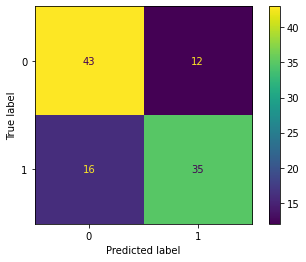

In [ ]:
cria_confusion_matrix(modelo_gradbc)

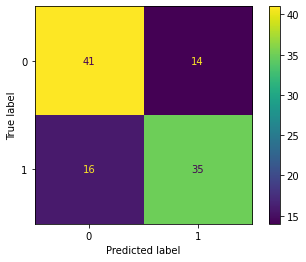

In [ ]:
cria_confusion_matrix(modelo_lgbm)

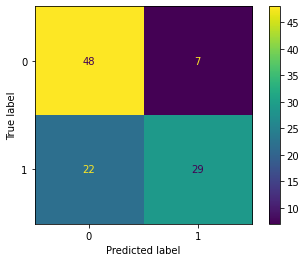

In [ ]:
cria_confusion_matrix(modelo_rdnforest)

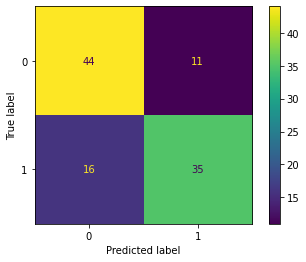

In [ ]:
cria_confusion_matrix(modelo_xgb)

### **Gráfico da curva ROC**

A curva ROC (Receiver Operating Characteristic) mostra visualmente o limiar da relação entre falsos positivos e verdadeiro positivos do modelo. Quanto mais alto o limiar, maior é a taxa de verdadeiro positivo (TP) e também maior será a taxa de falso positivo (FP). 

No hipotético caso extremo em que todos os exemplos são colocados na classe positiva, vemos que ambas as taxas chegam a 100%, enquanto no outro extremo, ambas ficam em 0%. É por isso que, quanto mais próxima a curva estiver do canto superior esquerdo, melhor é a predição do modelo, considerando que ele teria 100% de TPR e 0% de FPR. A linha tracejada serve como uma base de comparação, ela representa qual seria a curva de um classificador que prevê classes de forma aleatória.

Uma métrica muito popular e também utilizada neste projeto é o AUC (Area Under the ROC Curve), ou ROC AUC score, que calcula a área sob a curva ROC para medir o desempenho do modelo.

Por que usá-la? ROC AUC score é muito bom pra calcular o desempenho do modelo em fazer predições, é indicado quando os dados são bem balanceados, e também deve ser utilizado quando as classes positivas e negativas são igualmente importantes, o que é o nosso caso. É de extrema importância que o nosso modelo seja capaz de prever corretamente tanto quem vai para a UTI, quanto quem não vai para a UTI. Não queremos que um paciente receba alta e mais tarde volte em uma condição muito crítica e até mesmo vindo a falecer por um erro de previsão. O inverso também é relevante, porque não queremos disperdiçar recursos com um paciente que não necessitará de UTI, mas que por um erro do modelo foi classificado como um paciente positivo para UTI, desperdiçando recursos preciosos do hospital.

In [ ]:
def grafico_roc_curve(modelo):

  # Calcula o fpr (False Positive Rate) e tpr (True Positive Rate) para todos os thresholds
  probs = modelo.predict_proba(x_teste)
  preds = probs[:,1]
  fpr, tpr, threshold = metrics.roc_curve(y_teste, preds)
  roc_auc = metrics.auc(fpr, tpr)


  # Gráfico
  plt.figure(figsize=(12,6))
  plt.title('Curva ROC', fontsize=16)
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate', fontsize=14)
  plt.xlabel('False Positive Rate', fontsize=14)
  plt.show()

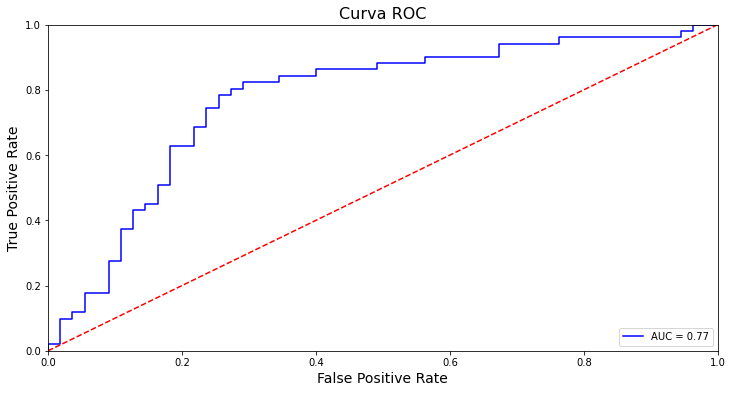

In [ ]:
grafico_roc_curve(modelo_gradbc)

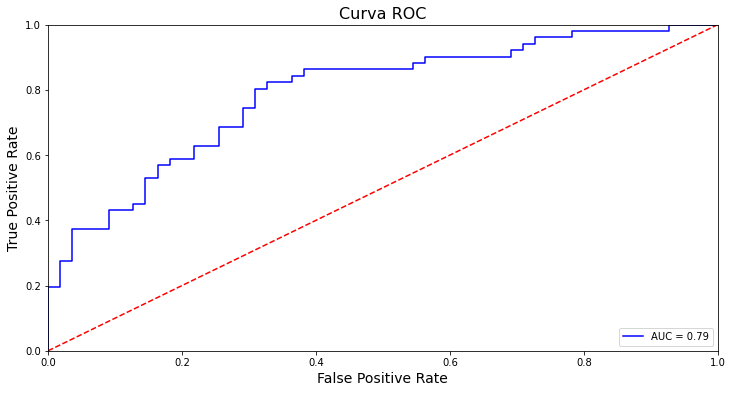

In [ ]:
grafico_roc_curve(modelo_lgbm)

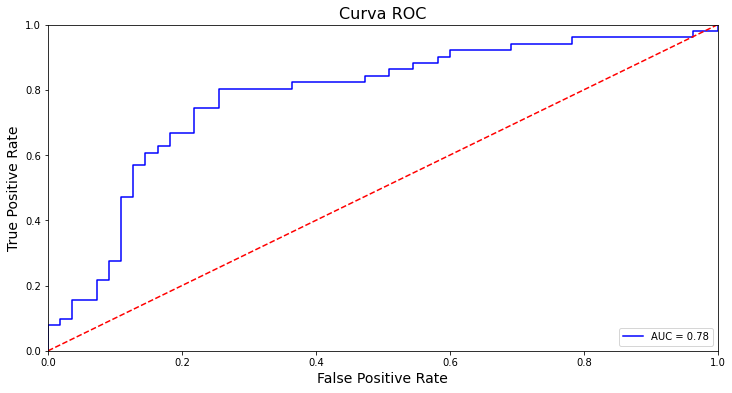

In [ ]:


grafico_roc_curve(modelo_rdnforest)

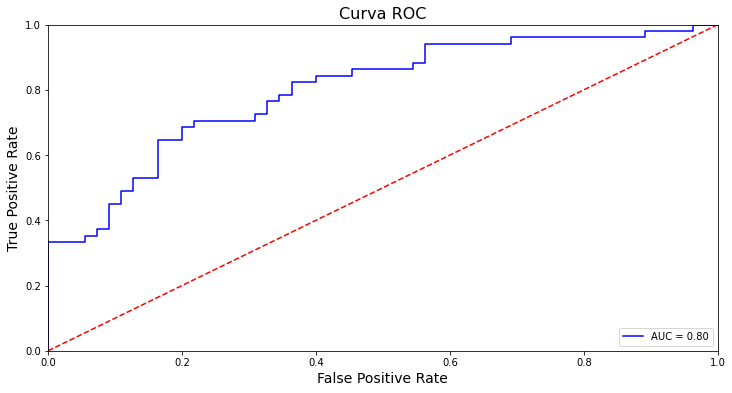

In [ ]:
grafico_roc_curve(modelo_xgb)

**Comparando os modelos pelo gráfico ROC AUC**

No gráfico abaixo podemos ver que os modelos XGBClassifier e LGBMClassifier são os que mais se aproximaram do canto esquerdo superior, o que significa que ambos os modelos são os melhores nas previsões.

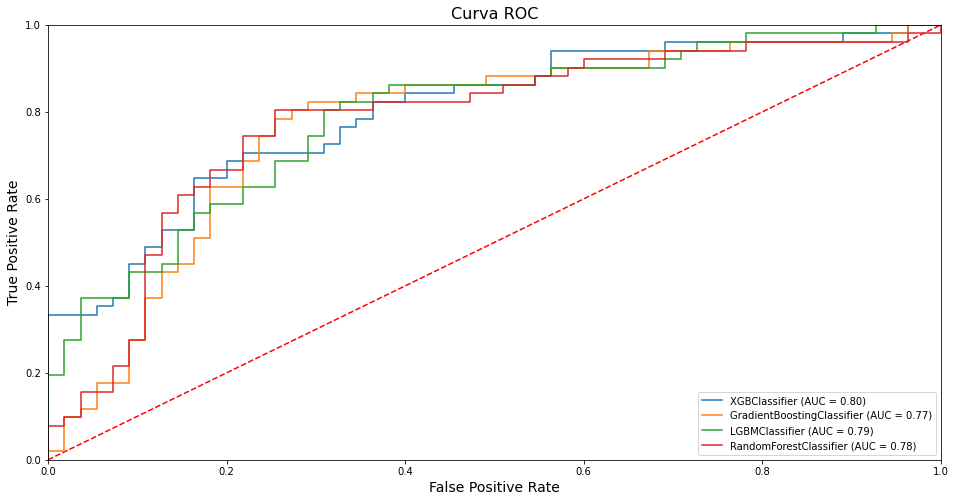

In [ ]:
# gráfico curva ROC com todos os modelos juntos
classifiers = [modelo_xgb, modelo_gradbc, modelo_lgbm, modelo_rdnforest]
plt.figure(figsize=(16,8))
ax = plt.gca()
plt.title('Curva ROC', fontsize=16)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
for i in classifiers:
    plot_roc_curve(i, x_teste, y_teste, ax=ax)

### **Kolmogorov-Smirnov plot and statistic**

**Kolmogorov-Smirnov Statistic**

Avalia se os dados amostrais se aproximam razoavelmente de uma determinada
distribuição. O teste de Kolmogorov-Smirnov calcula a distância máxima (separação) entre as distribuições das classes positivas e negativas.

Se houver um limite para o qual todas as observações acima são verdadeiramente positivas e todas as observações abaixo são verdadeiramente negativas, obteremos uma estatística KS perfeita de 1,0.

O gráfico KS ajuda a avaliar a separação entre as distribuições de predição para classes positivas e negativas.

In [ ]:
# Função que gera gráficos de desempenho baseados nas métricas KS-statistic, learning curve, lift curve
def cria_graficos_KS_learningcurve_liftcurve(modelo, dados, n_splits, n_repeats, seletor_de_features):

    np.random.seed(3165)
    dados = dados.sample(frac=1)
    y = dados["ICU"]
    x = dados.drop(["ICU","WINDOW", 'PATIENT_VISIT_IDENTIFIER'], axis=1)

    pipeline = Pipeline([('cat_selector', seletor_de_features),
                         ('Modelo', modelo)])    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(pipeline, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_medio = np.mean(resultados['test_score'])
    auc_medio_treino = np.mean(resultados['train_score'])
    
    plot_ks_statistic(y_teste, y_proba2, title='Kolmogorov-Smirnov Statistic', figsize=(12,6), title_fontsize='large', text_fontsize='large')
    plt.show()

    skplt.estimators.plot_learning_curve(modelo, x, y, title='Curva de Aprendizado', cv=cv, random_state=3165, title_fontsize='large', text_fontsize='large')
    plt.show()

    plot_lift_curve(y_teste, y_proba2, figsize=(12,6), title_fontsize='large', text_fontsize='large')
    plt.show()



### Modelo 1

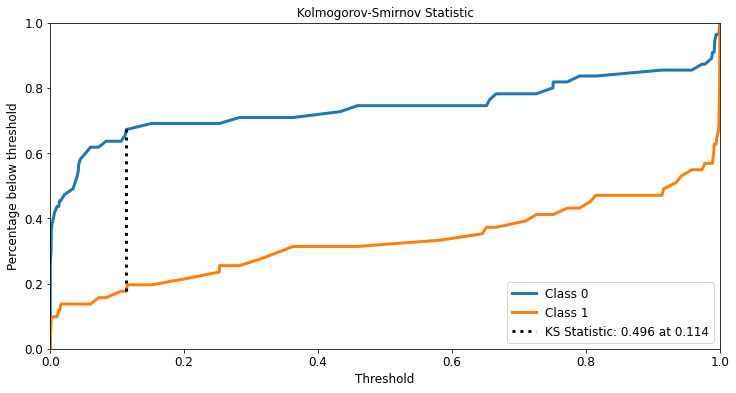

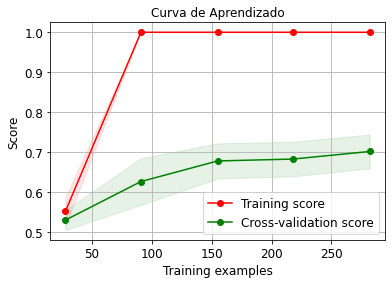

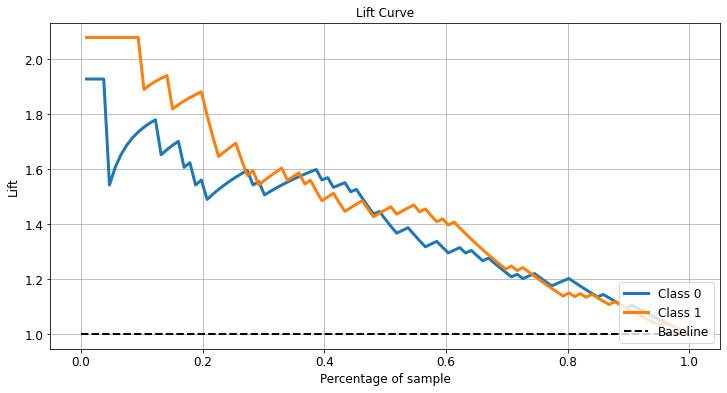

In [ ]:
# Modelo 1
cria_graficos_KS_learningcurve_liftcurve(modelo_lgbm, dados_finais, 5, 10, RemoveCorrVar())

### Modelo 2

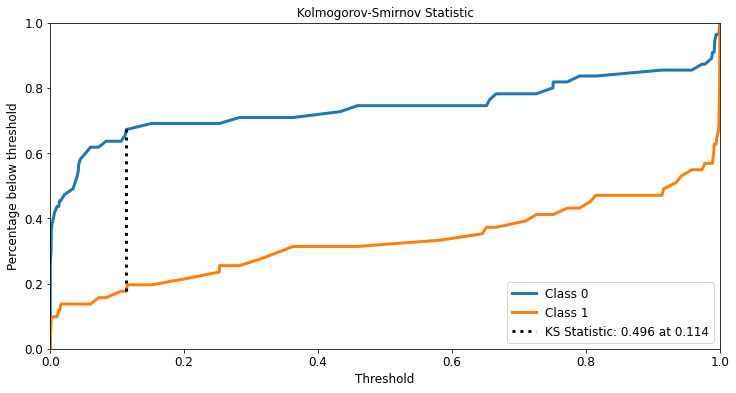

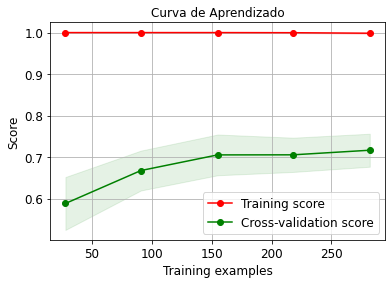

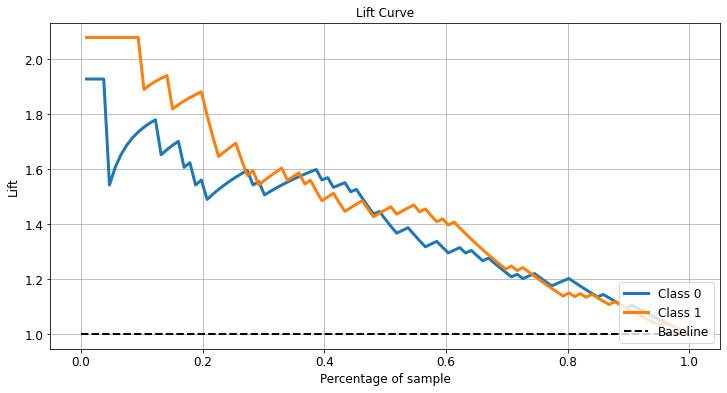

In [ ]:
# Modelo 2
cria_graficos_KS_learningcurve_liftcurve(modelo_xgb, dados_finais, 5, 10, RemoveCorrVar())

### Modelo 3

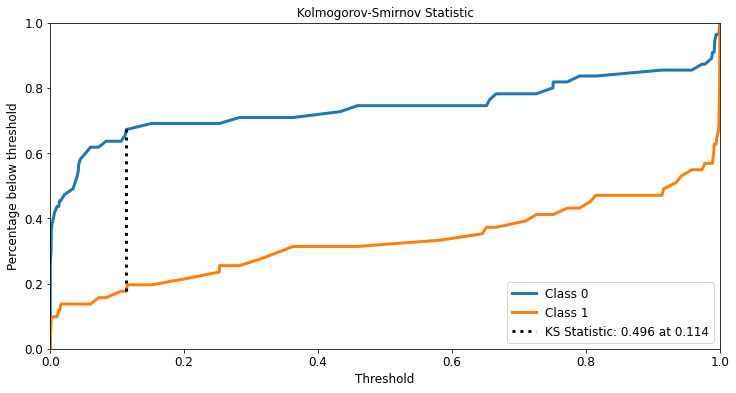

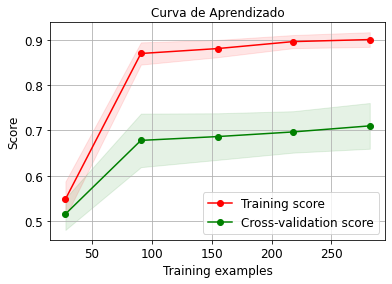

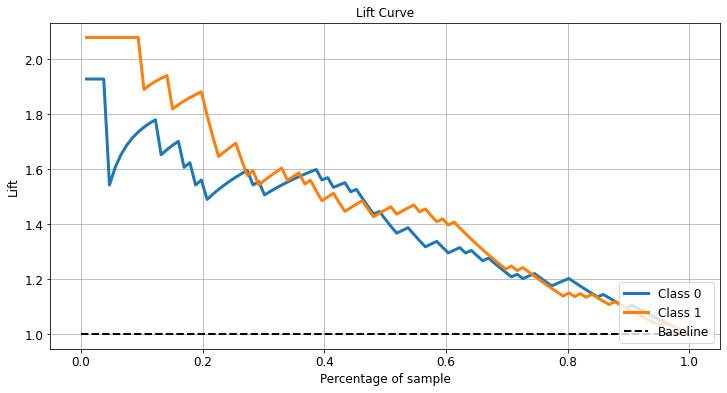

In [ ]:
# Modelo 3
cria_graficos_KS_learningcurve_liftcurve(modelo_gradbc, dados_finais, 5, 10, SelectKBest(k=100))

### Modelo 4

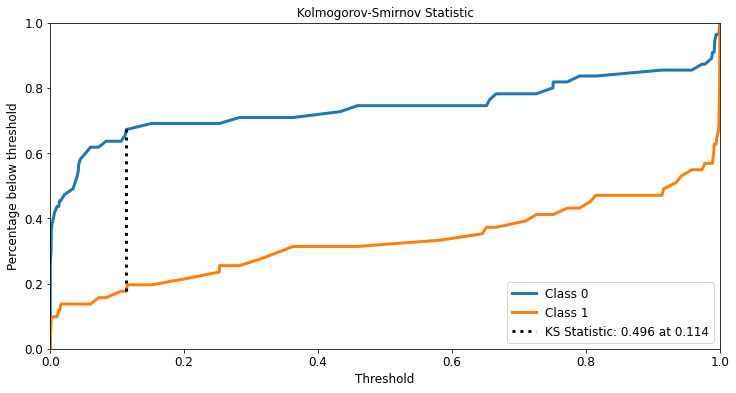

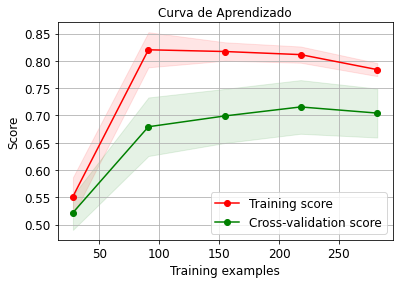

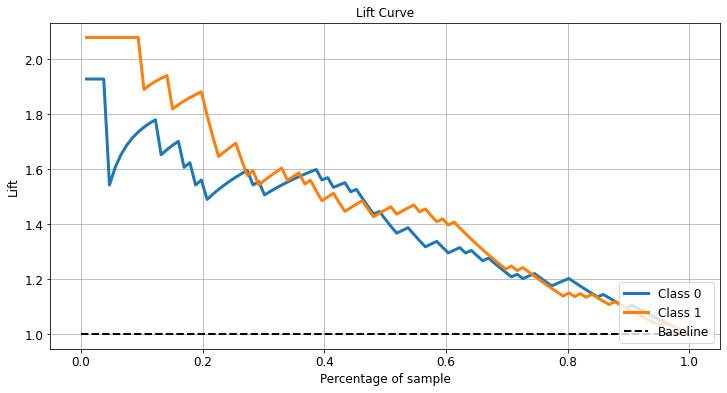

In [ ]:
# Modelo 4
cria_graficos_KS_learningcurve_liftcurve(modelo_rdnforest, dados_finais, 5, 10, VarianceThreshold())

### Modelo 5

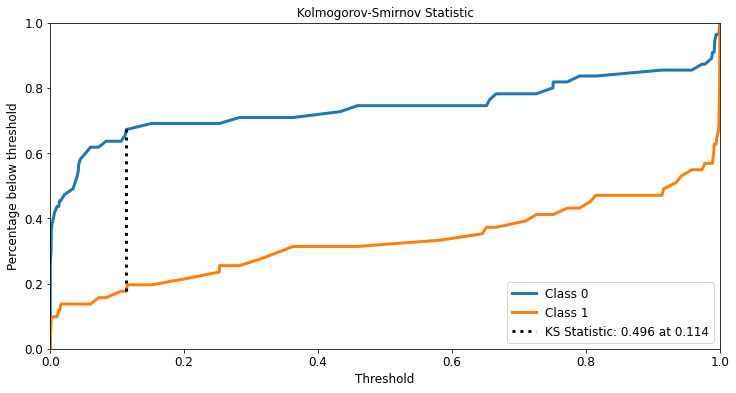

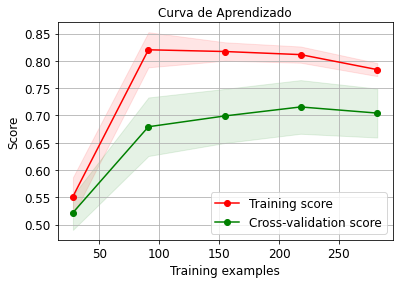

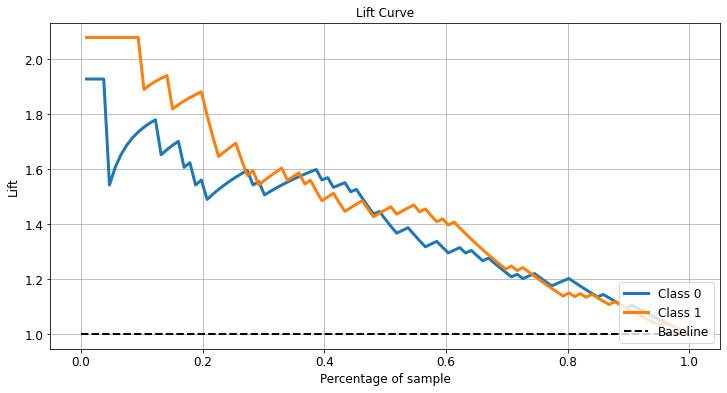

In [ ]:
# Modelo 5
cria_graficos_KS_learningcurve_liftcurve(modelo_rdnforest, dados_finais, 5, 10, SelectFromModel(estimator=modelo_rdnforest, max_features = 100))

### Modelo 6

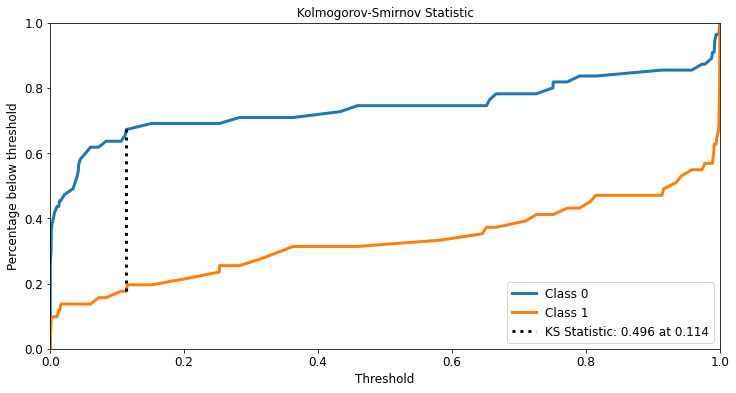

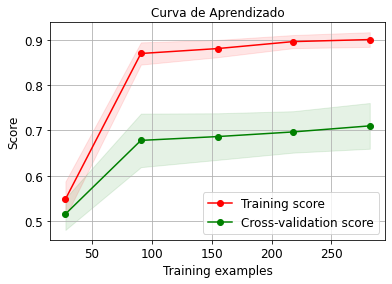

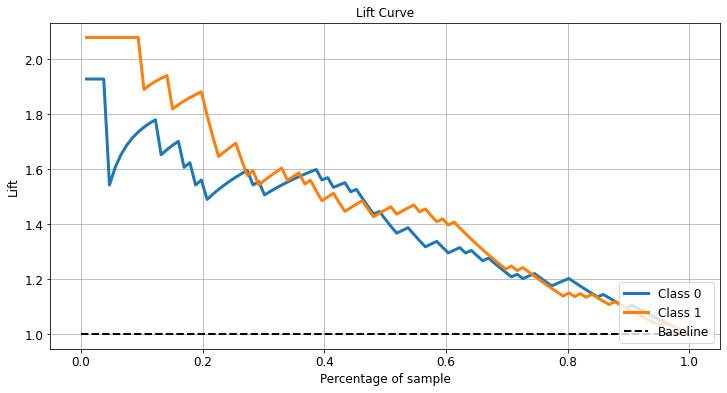

In [ ]:
# Modelo 6
cria_graficos_KS_learningcurve_liftcurve(modelo_gradbc, dados_finais, 5, 10, SelectFromModel(estimator=modelo_gradbc, max_features = 100))

### Modelo 7

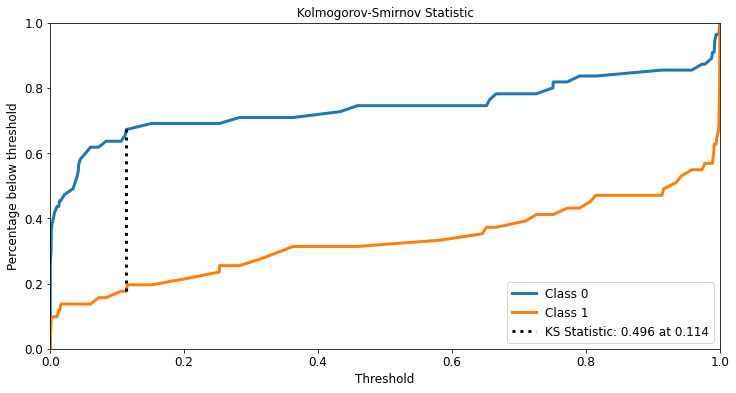

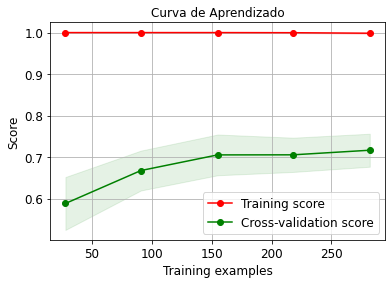

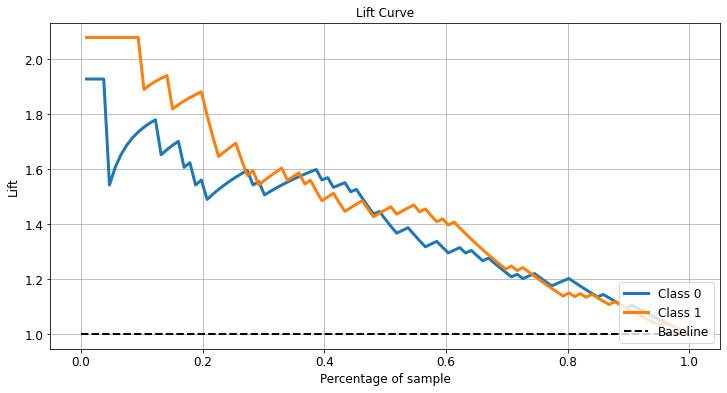

In [ ]:
# Modelo 7
cria_graficos_KS_learningcurve_liftcurve(modelo_xgb, dados_finais, 5, 10, SelectFromModel(estimator=modelo_xgb, max_features = 100))

### Modelo 8

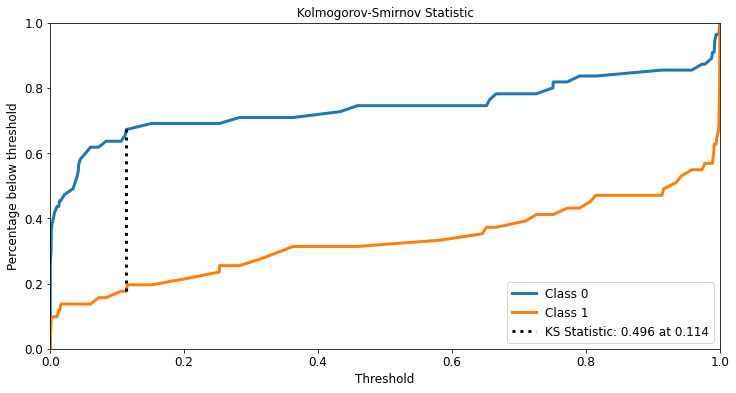

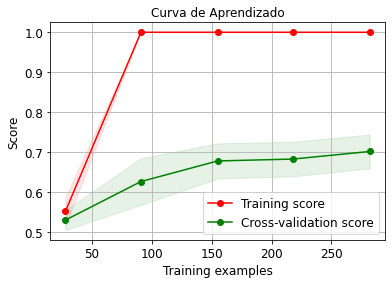

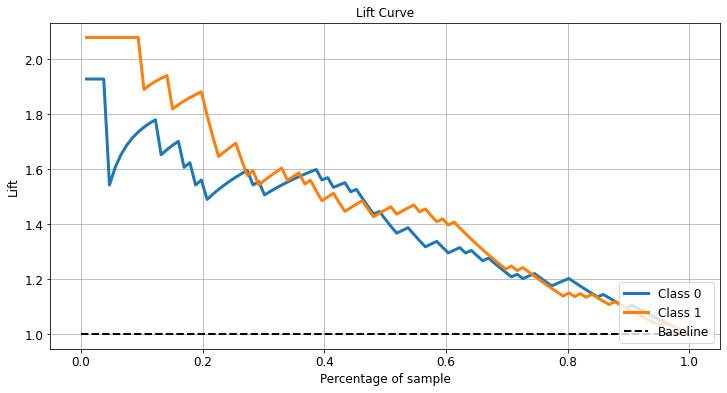

In [ ]:
# Modelo 8
cria_graficos_KS_learningcurve_liftcurve(modelo_lgbm, dados_finais, 5, 10, SelectFromModel(estimator=modelo_lgbm, max_features = 100))

### Modelo 9

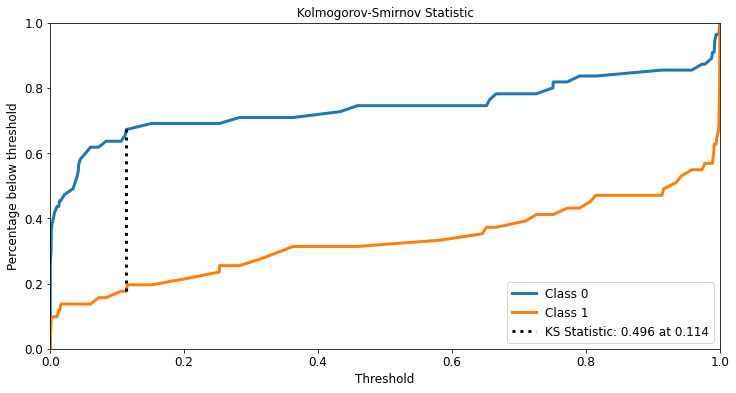

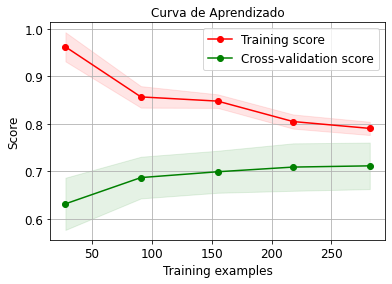

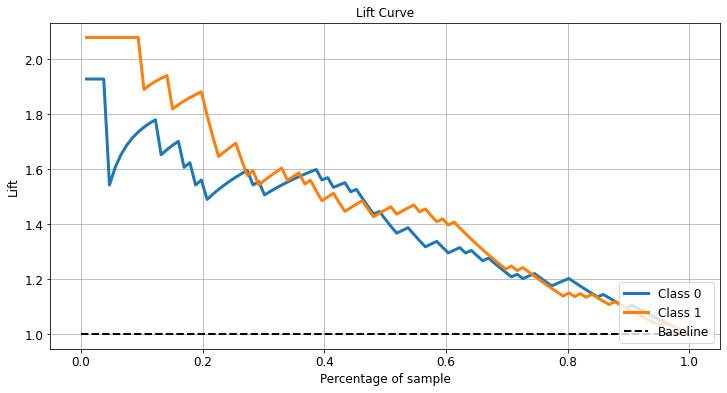

In [ ]:
# Modelo 9
cria_graficos_KS_learningcurve_liftcurve(base_LR, dados_finais, 5, 10, SelectFromModel(estimator=base_LR, max_features = 100))

# **Salvando os modelos**

Após analisar os gráficos decidi eliminar os modelos 6, 7, 8, 9.

In [ ]:
dump(modelo_lgbm, 'modelo_lgbm.joblib')

['modelo_lgbm.joblib']

In [ ]:
dump(modelo_xgb, 'modelo_xgb.joblib')

['modelo_xgb.joblib']

# **Conclusão**

Entre todos os modelos selecionados e testados com diferentes configurações, escolhi os modelos que usam os algoritmos LGBMClassifier e XGBClassifier com a função de seleção de features, RemoverCorrVar ou SelectFromModel. A escolha dos hiperparâmetros e até mesmo dos modelos em si foram feitas ustilizando o software de automação de configuração de modelos de machine learning, hyperopt-sklearn, que seleciona os melhores algoritmos e parâmetros baseado em testes estatísticos. Ele funciona como um pipenline de classificação em que reúne, os dados, preprocessamento, entre outros parâmetros para avaliar qual seria o melhor modelo e configuração de hiperparâmetros a serem utilizados pelo cientista de dados. O uso desta ferramenta auxiliou bastante o processo de criação e configuração dos nossos modelos de classificação binária, ajudando a ganhar tempo e ao mesmo tempo automatizando em parte o processo.

As métricas utilizadas para avaliar os melhores modelos foram, AUC ROC, Matriz de Confusão e Kolmogorov-Smirnov Statistic. Os escolhi por serem métricas em que ambas as classes positivas e negativas são importantes, por lidarem bem com dados relativamente balanceados e serem relativamente fáceis de interpretar.

Acredito que ainda daria para melhorar ainda mais os modelos se tivéssemos mais dados e tempo para testar mais ferramentas que possam melhorar no feature engeneering.

